### Importing libraries

In [20]:
# standard libraries
import numpy as np 
import pandas as pd 
import tensorflow as tf
import os

# Image related
import cv2
from PIL import Image

# Moedl evaluation
from sklearn import metrics 
from sklearn.metrics import f1_score,classification_report,roc_auc_score,auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import seaborn as sns
from collections import Counter
%matplotlib inline


# Keras library
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# Importing VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

# Time
import time
import datetime

In [3]:
# defining variables
data = []
labels = []
classes = 10
cur_path = os.getcwd()

# Retrieving the images and their labels 
for i in range(classes):
    train_dir = os.path.join('../input/gtsrb-german-traffic-sign/','train')
    # Listing all subdirectories 
    all_classes = os.listdir(train_dir)
    sorted_classes = sorted(all_classes, key=lambda x: int(x))
    
    # Selecting the first 10 classes
    selected_classes = sorted_classes[:10]
    
print(selected_classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [4]:
# Numebr of images per class
total_images = 0
for class_name in selected_classes:
    class_dir = os.path.join(train_dir, class_name)
    num_images = len(os.listdir(class_dir))
    total_images += num_images

# percentage distribution per class
for class_name in selected_classes:
    class_dir = os.path.join(train_dir, class_name)
    num_images = len(os.listdir(class_dir))
    print(f"Class: {class_name}, Number of Images: {num_images} , Percentage distribution:{np.round(num_images/total_images*100,2)}%")
print(f"Total Images: {total_images}")

Class: 0, Number of Images: 210 , Percentage distribution:1.43%
Class: 1, Number of Images: 2220 , Percentage distribution:15.13%
Class: 2, Number of Images: 2250 , Percentage distribution:15.34%
Class: 3, Number of Images: 1410 , Percentage distribution:9.61%
Class: 4, Number of Images: 1980 , Percentage distribution:13.5%
Class: 5, Number of Images: 1860 , Percentage distribution:12.68%
Class: 6, Number of Images: 420 , Percentage distribution:2.86%
Class: 7, Number of Images: 1440 , Percentage distribution:9.82%
Class: 8, Number of Images: 1410 , Percentage distribution:9.61%
Class: 9, Number of Images: 1470 , Percentage distribution:10.02%
Total Images: 14670


In [9]:
# Loading a subset of data 
max_images_per_class = 1000 # 1000 images per class
images = []
labels = []

for class_id, class_name in enumerate(selected_classes):
    class_dir = os.path.join(train_dir, class_name)
    img_files = os.listdir(class_dir)[:max_images_per_class]
    for img_file in img_files: 
        img_path = os.path.join(class_dir, img_file)  
        try:
            img = Image.open(img_path).resize((224,224)) # input format of VGG
            img = np.array(img)
            if img.shape[2] == 4:  
                img = img[:,:,:3]  # Keep only the first 3 channels (RGB)
            images.append(img)
            labels.append(class_id)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            continue

X = np.array(images)
y = np.array(labels)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (8630, 224, 224, 3)
y shape: (8630,)


Original Class Distribution: Counter({1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 7: 1000, 8: 1000, 9: 1000, 6: 420, 0: 210})
Balanced X shape: (10000, 224, 224, 3)
Balanced y shape: (10000,)
Balanced Class Distribution: Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000})


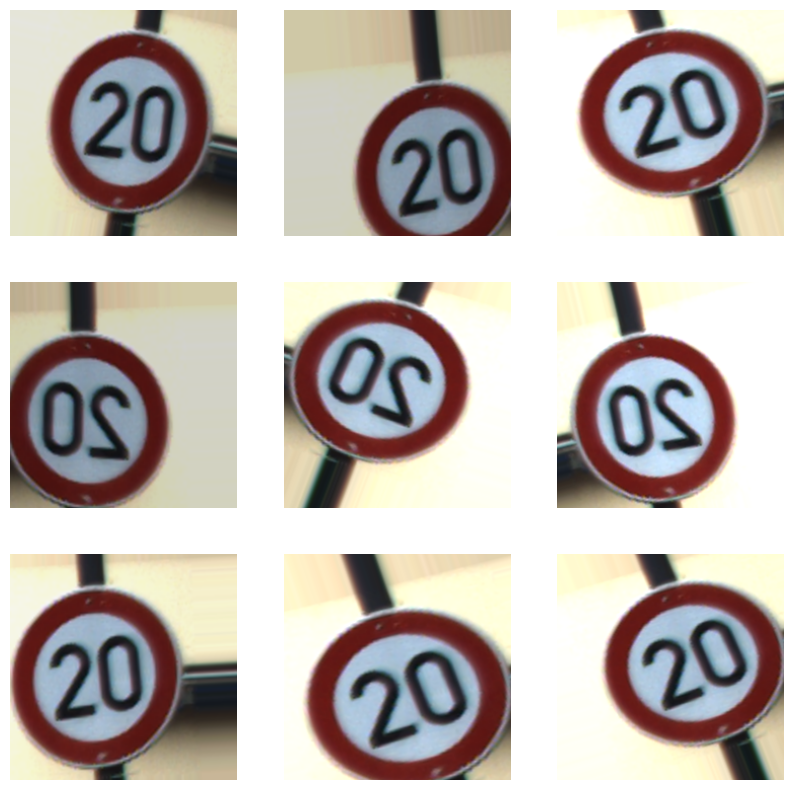

In [10]:
print("Original Class Distribution:", Counter(y))

# Applying Data augmentation on Minority classes to handle class imbalance
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Calculating max samples per class
max_samples = max(Counter(y).values())

# Augment images for each class
balanced_images = []
balanced_labels = []

for class_id in range(len(selected_classes)):
    class_images = X[y == class_id]
    class_count = len(class_images)
    
    balanced_images.extend(class_images)
    balanced_labels.extend([class_id] * class_count)
    
    images_to_augment = max_samples - class_count
    if images_to_augment > 0:
        augmented_flow = datagen.flow(class_images, batch_size=1)
        for _ in range(images_to_augment):
            aug_image = next(augmented_flow)[0].astype('uint8')
            balanced_images.append(aug_image)
            balanced_labels.append(class_id)

X_balanced = np.array(balanced_images)
y_balanced = np.array(balanced_labels)

print(f"Balanced X shape: {X_balanced.shape}")
print(f"Balanced y shape: {y_balanced.shape}")
print("Balanced Class Distribution:", Counter(y_balanced))

# Example of a augmented image
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    aug_img = datagen.random_transform(X_balanced[0])
    plt.imshow(aug_img.astype('uint8'))
    plt.axis('off')
plt.show()

### Preparing test data set

In [11]:
# Defining test dataset path
test_csv_path = os.path.join('../input/gtsrb-german-traffic-sign/Test.csv')
test_dir = '../input/gtsrb-german-traffic-sign/'

# Load the Test.csv file
test_df = pd.read_csv(test_csv_path)

# Filter for selected class IDs (0-9)
selected_classes = list(range(10)) 
filtered_test_df = test_df[test_df['ClassId'].isin(selected_classes)]

# Initialize lists to store test images and labels
test_images = []
test_labels = []

# Loop through the filtered DataFrame
for _, row in filtered_test_df.iterrows():
    img_path = os.path.join(test_dir,row['Path'])
    class_id = row['ClassId']
    try:
        img = Image.open(img_path).resize((224, 224))  # Resize for VGG16
        img = np.array(img)
        if img.shape[2] == 4:  # Handle RGBA images
            img = img[:, :, :3]
        test_images.append(img)
        test_labels.append(class_id)
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        continue

# Convert lists to numpy arrays
X_test = np.array(test_images)
y_test = np.array(test_labels)

# Normalize test images to range [0, 1]
X_test = X_test.astype('float32') / 255.0

# Print shapes to verify
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Test data shape: (4800, 224, 224, 3)
Test labels shape: (4800,)


#### splitting dataset into train and validation 

In [12]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

# Shape of train and val datasets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}\n")

print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

# Normalize the images to [0, 1] range
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

X_train shape: (6904, 224, 224, 3)
y_train shape: (6904,)

X_val shape: (1726, 224, 224, 3)
y_val shape: (1726,)


In [13]:
# Define a data generator class to import data
class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size,num_classes):
        self.X = X
        self.y = to_categorical(y, num_classes=num_classes)
        self.batch_size = batch_size
        self.indices = np.arange(len(y))

    def __len__(self):
        return int(np.ceil(len(self.y) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X = self.X[batch_indices]
        batch_y = self.y[batch_indices]
        return batch_X, batch_y

# Create data generators for training and validation
batch_size = 16  # small batch size to manage memory
train_gen = DataGenerator(X_train, y_train, batch_size,num_classes =10)
val_gen = DataGenerator(X_val, y_val, batch_size,num_classes =10)

## Defining the Deep Neural Network Model

In [14]:
# Load the pretrained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to retain pretrained weights
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)  # Add a dense layer
x = Dropout(0.3)(x)  # Add dropout to reduce overfitting
output = Dense(10, activation='softmax')(x)  # Final layer for 10 classes

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
from tensorflow.keras.losses import CategoricalCrossentropy

loss_fn = CategoricalCrossentropy()

model.compile(optimizer=Adam(), loss=loss_fn, metrics=['auc'])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,565,386 (105.15 MB)

 Trainable params: 12,850,698 (49.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

#### training the model 

In [15]:
# Callbacks for tracking and optimization
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(patience=20, monitor='val_loss', mode='min', restore_best_weights=True)
csv_logger = CSVLogger('training_log.csv')

# Train the model using the generators
history = model.fit(
    train_gen,
    epochs=25,
    validation_data=val_gen,
    callbacks=[checkpoint, early_stopping, csv_logger],
    verbose=1
)

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734440726.312912      95 service.cc:145] XLA service 0x784d3c002c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734440726.312986      95 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734440726.312991      95 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  3/432 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - auc: 0.5140 - loss: 4.3075  

I0000 00:00:1734440736.703500      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


432/432 ━━━━━━━━━━━━━━━━━━━━ 63s 120ms/step - auc: 0.7518 - loss: 2.6164 - val_auc: 0.9420 - val_loss: 1.0816
Epoch 2/25
432/432 ━━━━━━━━━━━━━━━━━━━━ 39s 91ms/step - auc: 0.9323 - loss: 1.0851 - val_auc: 0.9641 - val_loss: 0.8444
Epoch 3/25
432/432 ━━━━━━━━━━━━━━━━━━━━ 43s 99ms/step - auc: 0.9520 - loss: 0.9166 - val_auc: 0.9752 - val_loss: 0.6880
Epoch 4/25
432/432 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - auc: 0.9682 - loss: 0.7458 - val_auc: 0.9808 - val_loss: 0.6072
Epoch 5/25
432/432 ━━━━━━━━━━━━━━━━━━━━ 42s 96ms/step - auc: 0.9774 - loss: 0.6323 - val_auc: 0.9888 - val_loss: 0.4705
Epoch 6/25
432/432 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - auc: 0.9792 - loss: 0.6030 - val_auc: 0.9875 - val_loss: 0.4835
Epoch 7/25
432/432 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - auc: 0.9833 - loss: 0.5382 - val_auc: 0.9903 - val_loss: 0.4135
Epoch 8/25
432/432 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - auc: 0.9834 - loss: 0.5369 - val_auc: 0.9923 - val_loss: 0.3952
Epoch 9/25
432/432 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/s

### Model Evaluation on Test Set

In [22]:
# Load the best model
model.load_weights('best_model.keras')

# Assuming test_gen is the data generator that provides batches
test_gen = DataGenerator(X_test, y_test, batch_size, num_classes=10)

# Predict on the test set (this will give you the probabilities for each class)
test_predictions = model.predict(test_gen)
test_classes = np.argmax(test_predictions, axis=1)

# Classificatio report
print(classification_report(y_test, test_classes))

  3/300 ━━━━━━━━━━━━━━━━━━━━ 26s 89ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step
              precision    recall  f1-score   support

           0       1.00      0.52      0.68        60
           1       0.81      0.89      0.85       720
           2       0.79      0.78      0.79       750
           3       0.57      0.66      0.61       450
           4       0.92      0.63      0.75       660
           5       0.57      0.83      0.68       630
           6       1.00      0.73      0.85       150
           7       0.85      0.75      0.80       450
           8       0.79      0.75      0.77       450
           9       0.94      0.86      0.89       480

    accuracy                           0.77      4800
   macro avg       0.83      0.74      0.77      4800
weighted avg       0.79      0.77      0.77      4800



In [23]:
# Test AUC
print(f"Test AUC: {roc_auc_score(y_test, test_predictions, multi_class='ovr'):.4f}")

Test AUC: 0.9621


#### Visualisation of model performance
* Confusion Matrix
* Precision-Recall Curve

<Figure size 1000x500 with 0 Axes>

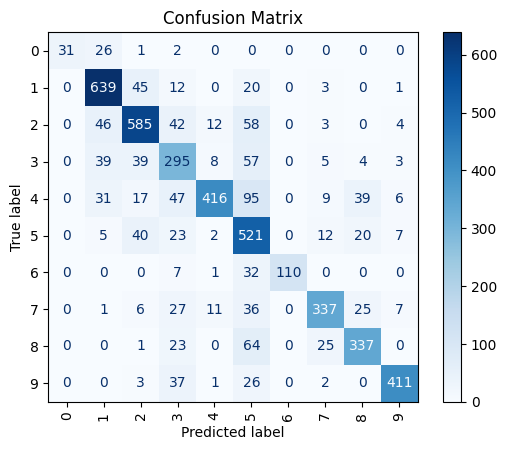

----------------------------------------------------------------------------------------------------


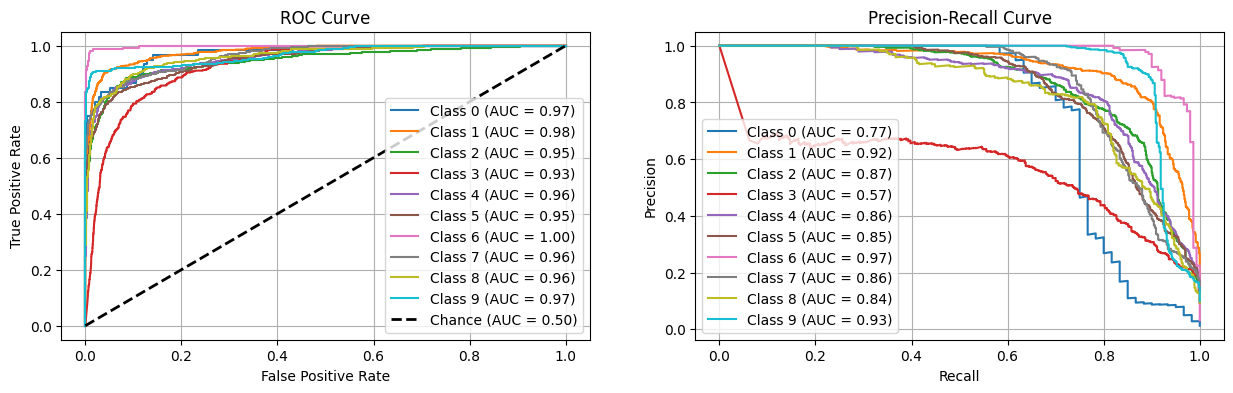

In [24]:
# Confusion Matrix
plt.figure(figsize=(10, 5))
cm = confusion_matrix(y_test, test_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_classes)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve subplot 
print('-'*100)
fpr = {}
tpr = {}
roc_auc = {}

y_test_onehot = np.zeros((len(y_test), len(selected_classes)))
y_test_onehot[np.arange(len(y_test)), y_test] = 1

for i, class_name in enumerate(selected_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (15,4))
plt.subplot(1, 2, 1)
for i, class_name in enumerate(selected_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_name} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Chance (AUC = 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()

# Precision-Recall Curve subplot 
precision = {}
recall = {}
pr_auc = {}

plt.subplot(1, 2, 2)
for i, class_name in enumerate(selected_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_onehot[:, i], test_predictions[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

    plt.plot(recall[i], precision[i], label=f"Class {class_name} (AUC = {pr_auc[i]:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()

# Show the plots
plt.show()

### Model Error Evalaution

In [41]:
# Filter misclassified samples 
misclassified_indices = np.where(y_test != test_classes)[0]
misclassified_0 = [i for i in misclassified_indices if y_test[i] == 0]
misclassified_3 = [i for i in misclassified_indices if y_test[i] == 3]

# Extract misclassified images
misclassified_samples_3 = X_test[misclassified_3]
misclassified_samples_0 = X_test[misclassified_0]

#### Misclassified samples class 3

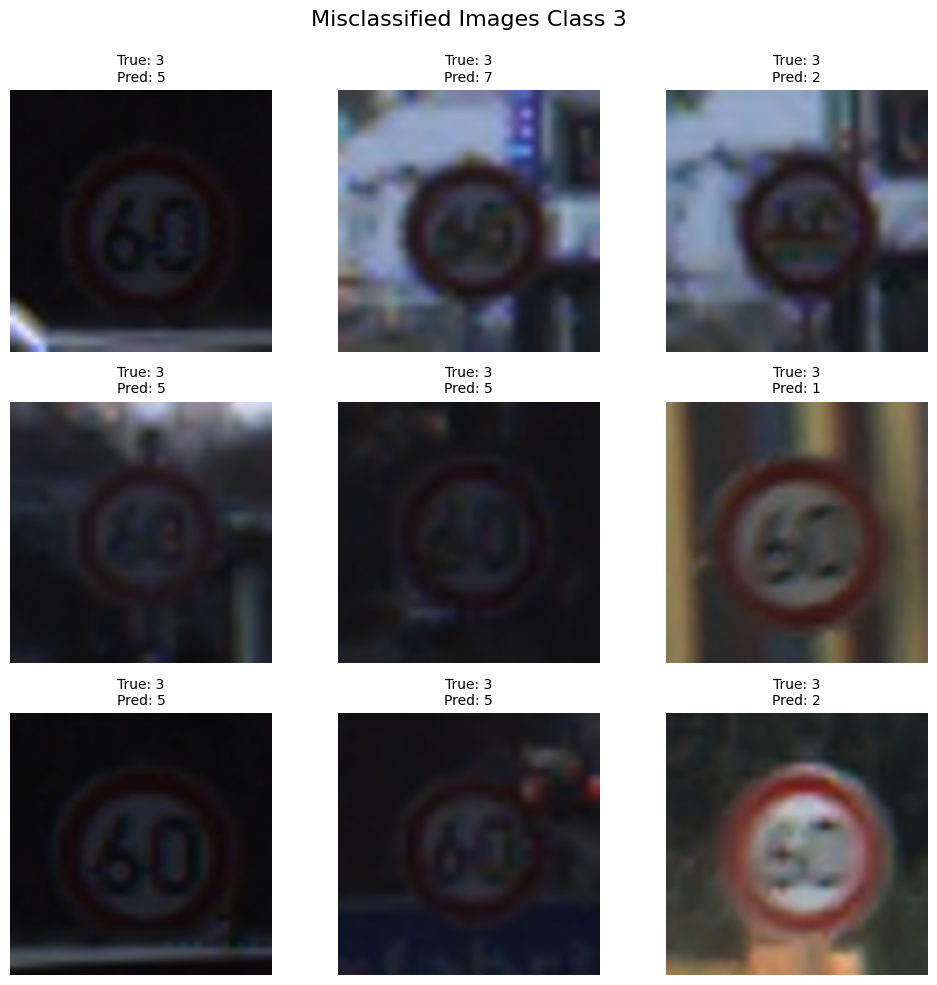

In [42]:
# Example of 9 images of class 3 that are misclassifed
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle("Misclassified Images Class 3", fontsize=16)

for i in range(9):
    idx = misclassified_3[i]
    image = misclassified_samples_3[i]
    true_label = y_test[idx]
    predicted_label = test_classes[idx]

    # Reverse normalization and convert the image back to uint8
    image = image * 255
    image = image.astype('uint8')
    
    # Select subplot
    ax = axes[i // 3, i % 3] 
    ax.imshow(image)
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
    ax.axis('off')  #

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(top=0.9)  
plt.show()


#### Misclassified samples class 0

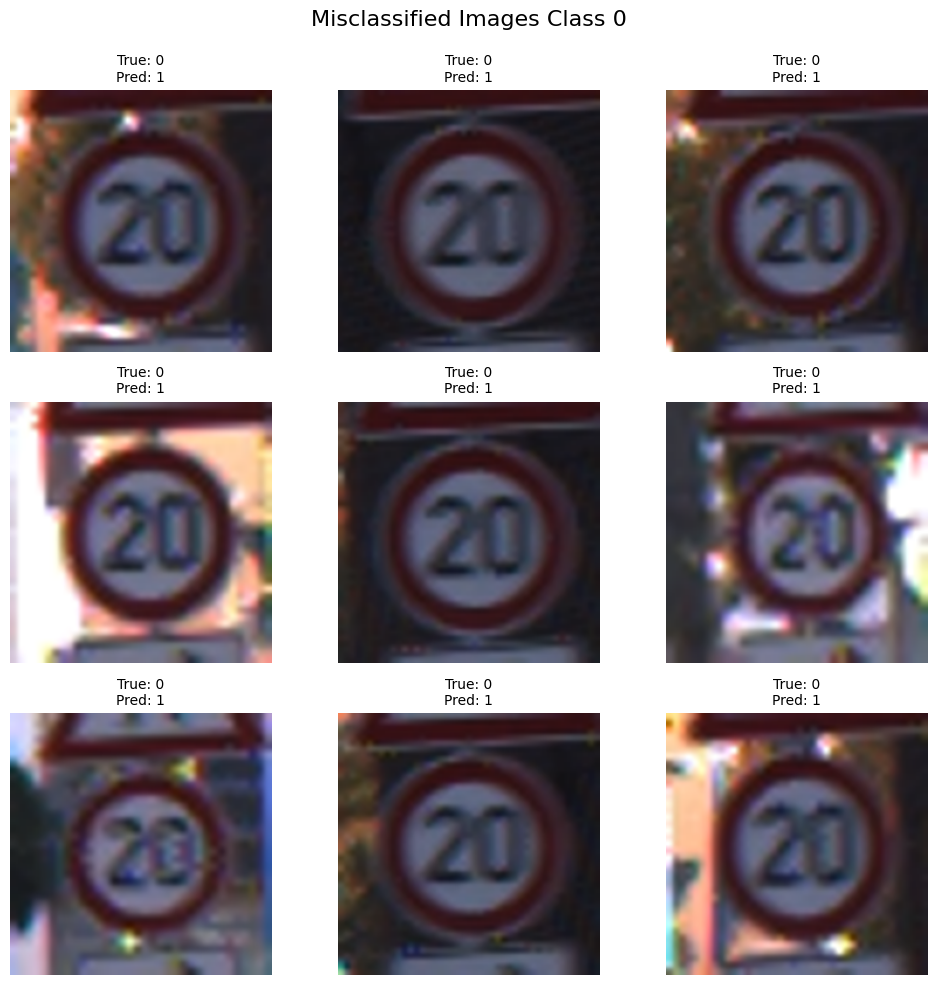

In [43]:
# Example of 9 images of class 3 that are misclassifed
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle("Misclassified Images Class 0", fontsize=16)

for i in range(9):
    idx = misclassified_0[i]
    image = misclassified_samples_0[i]
    true_label = y_test[idx]
    predicted_label = test_classes[idx]

    # Reverse normalization and convert the image back to uint8
    image = image * 255
    image = image.astype('uint8')
    
    # Select subplot
    ax = axes[i // 3, i % 3] 
    ax.imshow(image)
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
    ax.axis('off')  #

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(top=0.9)  
plt.show()

### Save the model

In [45]:
model.save('road_sign_classifier.h5')